# Using LinearDiscriminantAnalysis()

# Manual implementation with equation

In [57]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from PIL import Image
import clip
import numpy as np

# # Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

# Load CSV file
csv_path = 'cat_dog1.csv'
data = pd.read_csv(csv_path)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [58]:

# Utilize the CLIP model to extract embeddings for each image in the dataset (both train and test dataset)
train_embeddings = []
test_embeddings = []

for image_path in train_data['image']:
    # Load image using PIL and apply transformations
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        # embedding = model.encode_image(image)
        train_embeddings.append(model.encode_image(image).float().cpu().numpy())

for image_path in test_data['image']:
    # Load image using PIL and apply transformations
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        # embedding = model.encode_image(image)
        test_embeddings.append(model.encode_image(image).float().cpu().numpy())

In [59]:
# Assuming your CSV has 'image' and 'labels' columns
X_train = np.vstack(train_embeddings)
X_test = np.vstack(test_embeddings)

# images = df['image'].values
# labels = df['labels'].values
y_train = train_data['labels'].values
y_test = test_data['labels'].values


In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [61]:
C = [0.1]

# Calculate the mean for each class
cat_mean = np.mean(X_train_std[y_train == 0], axis=0)
dog_mean = np.mean(X_train_std[y_train == 1], axis=0)

# Calculate the within-class scatter matrix
Sw = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i in range(X_train_std.shape[0]):
    if y_train[i] == 0:
        Sw += np.dot((X_train_std[i] - cat_mean).reshape(-1, 1), (X_train_std[i] - cat_mean).reshape(1, -1))
    else:
        Sw += np.dot((X_train_std[i] - dog_mean).reshape(-1, 1), (X_train_std[i] - dog_mean).reshape(1, -1))

Sw_inv = np.linalg.inv(Sw)

w = C * np.dot(Sw_inv, (cat_mean - dog_mean).reshape(-1, 1))

# Calculate the projected values for each class
y_pred = np.dot(X_test_std, w)
y_pred[y_pred >= 0] = 0
y_pred[y_pred < 0] = 1


In [62]:
print('Shape of y_test:', y_test.shape)
print('Shape of y_pred:', y_pred.shape)

Shape of y_test: (400,)
Shape of y_pred: (400, 1)


In [64]:
# Classify using Fisher's Linear Discriminant
threshold = 0.0
y_test_pred = np.where(y_pred > threshold, 1, 0)

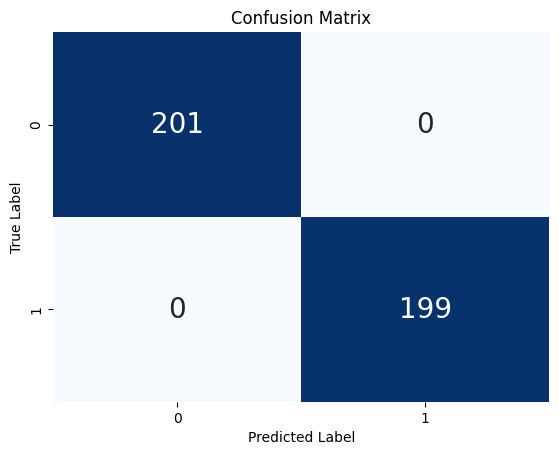

Accuracy: 1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


In [68]:
#Visualize Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_test_pred)
def fisher_discriminent(X_train, y_train, X_test, y_test, threshold, cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                annot_kws={'size': 20}, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

fisher_discriminent(X_train_std, y_train, X_test_std, y_test, threshold, conf_matrix)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))


# Change C values in Manual Implementation

In [66]:
C1 = 0.01
C2 = 10
C3 = 1.0

#Calculate the weight
w1 = C1 * np.dot(Sw_inv, (cat_mean - dog_mean).reshape(-1, 1))
w2 = C2 * np.dot(Sw_inv, (cat_mean - dog_mean).reshape(-1, 1))
w3 = C3 * np.dot(Sw_inv, (cat_mean - dog_mean).reshape(-1, 1))

#Calculate the predicted values for each class
y_pred1 = np.dot(X_test_std, w1)
y_pred2 = np.dot(X_test_std, w2)
y_pred3 = np.dot(X_test_std, w3)

y_pred1[y_pred1 >= 0] = 0
y_pred1[y_pred1 < 0] = 1

y_pred2[y_pred2 >= 0] = 0
y_pred2[y_pred2 < 0] = 1

y_pred3[y_pred3 >= 0] = 0
y_pred3[y_pred3 < 0] = 1

y_test_pred1 = np.where(y_pred1 > threshold, 1, 0)
y_test_pred2 = np.where(y_pred2 > threshold, 1, 0)
y_test_pred3 = np.where(y_pred3 > threshold, 1, 0)

#Visualize Confusion Matrix
cm1 = confusion_matrix(y_test, y_test_pred1)
cm2 = confusion_matrix(y_test, y_test_pred2)
cm3 = confusion_matrix(y_test, y_test_pred3)

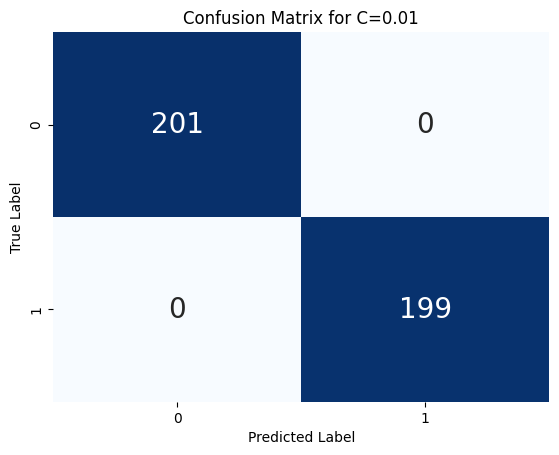

Accuracy for C=0.01: 1.0
Precision for C=0.01: 1.0
Recall for C=0.01: 1.0
F1-score for C=0.01: 1.0




In [73]:
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 20}, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for C=0.01')
plt.show()

#Calculate the accuracy, precision, recall and f1 score for each class
accuracy1 = accuracy_score(y_test, y_test_pred1)
precision1 = precision_score(y_test, y_test_pred1)
recall1 = recall_score(y_test, y_test_pred1)
f1_1 = f1_score(y_test, y_test_pred1)

#Print the accuracy, precision, recall and f1 score for each class
print('Accuracy for C=0.01:', accuracy1)
print('Precision for C=0.01:', precision1)
print('Recall for C=0.01:', recall1)
print('F1-score for C=0.01:', f1_1)
print('\n')

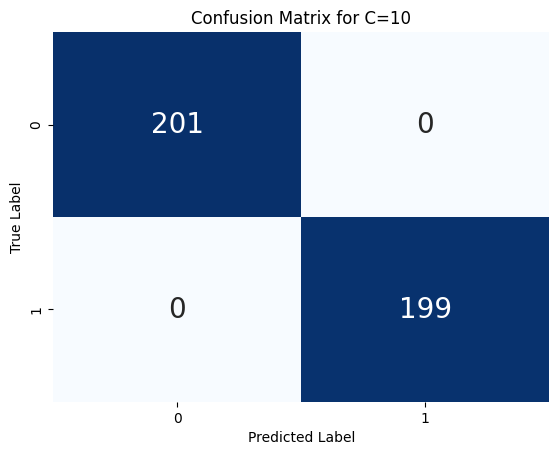

Accuracy for C=10: 1.0
Precision for C=10: 1.0
Recall for C=10: 1.0
F1-score for C=10: 1.0




In [74]:
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 20}, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for C=10')
plt.show()

accuracy2 = accuracy_score(y_test, y_test_pred2)
precision2 = precision_score(y_test, y_test_pred2)
recall2 = recall_score(y_test, y_test_pred2)
f1_2 = f1_score(y_test, y_test_pred2)

print('Accuracy for C=10:', accuracy2)
print('Precision for C=10:', precision2)
print('Recall for C=10:', recall2)
print('F1-score for C=10:', f1_2)
print('\n')

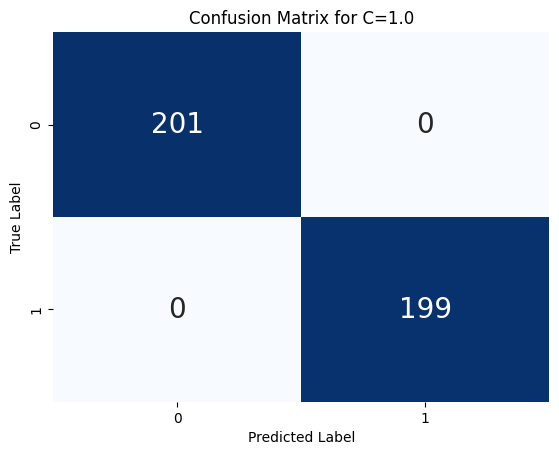

Accuracy for C=1.0: 1.0
Precision for C=1.0: 1.0
Recall for C=1.0: 1.0
F1-score for C=1.0: 1.0




In [75]:
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 20}, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for C=1.0')
plt.show()

accuracy3 = accuracy_score(y_test, y_test_pred3)
precision3 = precision_score(y_test, y_test_pred3)
recall3 = recall_score(y_test, y_test_pred3)
f1_3 = f1_score(y_test, y_test_pred3)


print('Accuracy for C=1.0:', accuracy3)
print('Precision for C=1.0:', precision3)
print('Recall for C=1.0:', recall3)
print('F1-score for C=1.0:', f1_3)
print('\n')

In [77]:
#print the confusiocn matrix for each class
print('Confusion Matrix for C=0.1:\n', conf_matrix)
print('Confusion Matrix for C=0.01:\n', cm1)
print('Confusion Matrix for C=10:\n', cm2)
print('Confusion Matrix for C=1.0:\n', cm3)


Confusion Matrix for C=0.1:
 [[201   0]
 [  0 199]]
Confusion Matrix for C=0.01:
 [[201   0]
 [  0 199]]
Confusion Matrix for C=10:
 [[201   0]
 [  0 199]]
Confusion Matrix for C=1.0:
 [[201   0]
 [  0 199]]
